In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile
---

## VEST's Documentation File


Election results from Tennessee Secretary of State (https://sos.tn.gov/products/elections/election-results)
Precinct shapefile from Tennessee Comptroller's Office of Local Government

Hamilton County updated with new shapefile from the county's GIS department.

In some counties, early voting write-in votes are only reported countywide. These votes are apportioned to precincts in the same shares that the Election Day vote was split among precincts within a county.

G16PRERTru - Donald J. Trump (Republican Party) \
G16PREDCli - Hillary Clinton (Democratic Party) \
G16PREIDeL - Roque De La Fuente (Independent) \
G16PRELJoh - Gary Johnson (Libertarian Party) \
G16PRESKen - Alyson Kennedy (Independent) \ 
G16PREISmi - Mike Smith (Independent) \
G16PREGSte - Jill Stein (Green Party) \
G16PREOth - Write-in Votes

### Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/tn_2016/tn_2016.shp")

In [3]:
vest_shp.shape

(1983, 11)

In [4]:
vest_shp.head(1)

,NAME,VTD,G16PRERTru,G16PREDCli,G16PREIDeL,G16PRELJoh,G16PRESKen,G16PREISmi,G16PREGSte,G16PREOth,geometry
0,8,1611,427,84,0,11,0,2,1,0,"POLYGON ((1062297.672 552842.892, 1062351.220 ..."


<AxesSubplot:>

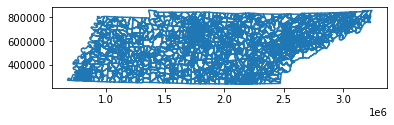

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['NAME', 'VTD', 'G16PRERTru', 'G16PREDCli', 'G16PREIDeL', 'G16PRELJoh',
       'G16PRESKen', 'G16PREISmi', 'G16PREGSte', 'G16PREOth', 'geometry'],
      dtype='object')

# Load the SOS File

The SOS directed to this link for election results for the 2016 general: https://sos.tn.gov/products/elections/election-results

In [7]:
# Import file
president_election_16 = pd.read_excel("./raw-from-source/2016_TN_Election_Results.xlsx")

In [8]:
president_election_16.head()

,COUNTY,PRCTSEQ,PRECINCT,BALSEQID,JURISID,CANDGROUP,OFFICENAME,ELECTDATE,ELECTTYPE,COL1HDG,...,PARTY8,PVTALLY8,COL9HDG,RNAME9,PARTY9,PVTALLY9,COL10HDG,RNAME10,PARTY10,PVTALLY10
0,Anderson,1,Andersonville,3,0,1,United States President,2016-11-08,State General,1,...,NaN,1.0,9.0,Write-In - Cherunda Fox,NaN,0.0,10.0,Write-In - Tom Hoefling,NaN,0.0
1,Anderson,1,Andersonville,3,0,2,United States President,2016-11-08,State General,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anderson,1,Andersonville,11,3,0,United States House of Representatives District 3,2016-11-08,State General,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Anderson,1,Andersonville,17,36,0,Tennessee House of Representatives District 36,2016-11-08,State General,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Anderson,2,Briceville,3,0,1,United States President,2016-11-08,State General,1,...,NaN,0.0,9.0,Write-In - Cherunda Fox,NaN,0.0,10.0,Write-In - Tom Hoefling,NaN,0.0


## Clean Up the Election Results
Tennessee had 8 different presidential write-in candidates and votes were counted seperately. All write-in votes have been been combined here.

In [9]:
# Filter down rows containing presidential election results
president_election_16 = president_election_16[president_election_16['OFFICENAME'] == 'United States President']

# Filter down columns
cols = ['COUNTY','PRECINCT','COL1HDG','PVTALLY1','PVTALLY2','PVTALLY3','PVTALLY4','PVTALLY5','PVTALLY6','PVTALLY7','PVTALLY8','PVTALLY9','PVTALLY10']
president_election_16 = president_election_16.reindex(columns = cols)

# Create dataframe consisting of first row of presidential election data
president_election_16_1 = president_election_16[president_election_16['COL1HDG'] != 11]
president_election_16_1.reset_index(drop=True, inplace = True)

# Create dataframe consisting of second row of presidential election data
president_election_16_2 = president_election_16[president_election_16['COL1HDG'] == 11]
president_election_16_2 = president_election_16_2.drop(['COUNTY','PRECINCT','COL1HDG','PVTALLY6','PVTALLY7','PVTALLY8','PVTALLY9','PVTALLY10'], axis = 1)

# Rename the columns to avoid duplicate column names
president_election_16_2.columns = ['PVTALLY11','PVTALLY12','PVTALLY13','PVTALLY14','PVTALLY15']
president_election_16_2.reset_index(drop=True, inplace = True)

# Concatenate the second dataframe to the first dataframe
president_election_16 = pd.concat([president_election_16_1,president_election_16_2], axis = 1, ignore_index = False)

# Add all the write-in votes
president_election_16['PVTALLY8'] = president_election_16.PVTALLY8 + president_election_16.PVTALLY9 + president_election_16.PVTALLY10 + president_election_16.PVTALLY11 + president_election_16.PVTALLY12 + president_election_16.PVTALLY13 + president_election_16.PVTALLY14 + president_election_16.PVTALLY15

# Drop all the write-in columns except for the column with sum of all the write-in votes
president_election_16 = president_election_16.drop(['COL1HDG','PVTALLY9','PVTALLY10','PVTALLY11','PVTALLY12','PVTALLY13','PVTALLY14','PVTALLY15'], axis = 1)

# Deal with the index
president_election_16.reset_index(drop=True, inplace = True)

#Rename the columns to match VEST
president_election_16.columns = ['County','Precinct','G16PRERTru', 'G16PREDCli', 'G16PREIDeL', 'G16PRELJoh',
       'G16PRESKen', 'G16PREISmi', 'G16PREGSte', 'G16PREOth']

#Fill n/a values with 0
president_election_16 = president_election_16.fillna(0)

# Validating Election Results

## Statewide Candidate Totals

In [10]:
data_columns = ['G16PRERTru', 'G16PREDCli', 'G16PREIDeL', 'G16PRELJoh',
       'G16PRESKen', 'G16PREISmi', 'G16PREGSte', 'G16PREOth']

print("Printing differences below")
for race in data_columns:
    if (sum(vest_shp[race])- president_election_16[race].sum() != 0):
        print(race+" has a difference of "+str(sum(vest_shp[race])-president_election_16[race].sum())+" votes")
        print("\tVEST: "+str(sum(vest_shp[race]))+" votes")
        print("\tSOURCES: "+str(president_election_16[race].sum())+" votes")
    else:
        print(race + " is equal", "\tVEST: " + str(sum(vest_shp[race])), "\tRDH: " + str(president_election_16[race].sum()))
print("")
print("All other races are equal")

Printing differences below
G16PRERTru is equal 	VEST: 1522925 	RDH: 1522925
G16PREDCli is equal 	VEST: 870695 	RDH: 870695.0
G16PREIDeL is equal 	VEST: 4075 	RDH: 4075.0
G16PRELJoh is equal 	VEST: 70397 	RDH: 70397.0
G16PRESKen is equal 	VEST: 2877 	RDH: 2877.0
G16PREISmi is equal 	VEST: 7276 	RDH: 7276.0
G16PREGSte is equal 	VEST: 15993 	RDH: 15993.0
G16PREOth has a difference of -3.0 votes
	VEST: 13786 votes
	SOURCES: 13789.0 votes

All other races are equal


## County Totals

### Add in County FIPs Data

In [11]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Tennessee"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
TN_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

#Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"DeKalb":"Dekalb"}
president_election_16["County"] = president_election_16["County"].map(county_name_changes_dict).fillna(president_election_16["County"])

#Use the dictionary to go from a county name to a county FIPS
president_election_16["County"] = president_election_16["County"].map(TN_fips_dict).fillna(president_election_16["County"])

# #Make sure the county names in the dataframe match the FIPs file
print(president_election_16["County"].unique())

#Check the number of counties - looking for 95
print(len(president_election_16["County"].unique()))

['001' '003' '005' '007' '009' '011' '013' '015' '017' '019' '021' '023'
 '025' '027' '029' '031' '033' '035' '037' '039' '041' '043' '045' '047'
 '049' '051' '053' '055' '057' '059' '061' '063' '065' '067' '069' '071'
 '073' '075' '077' '079' '081' '083' '085' '087' '089' '091' '093' '095'
 '097' '099' '101' '103' '105' '111' '113' '115' '117' '119' '107' '109'
 '121' '123' '125' '127' '129' '131' '133' '135' '137' '139' '141' '143'
 '145' '147' '149' '151' '153' '155' '157' '159' '161' '163' '165' '167'
 '169' '171' '173' '175' '177' '179' '181' '183' '185' '187' '189']
95


### Check the Results

In [12]:
vest_shp['NAME']

0                     8
1                     6
2               Mayland
3                Rinnie
4                 Woody
             ...       
1978          Concord 6
1979         Meadowview
1980          Concord 3
1981         Harrison 6
1982    Middle Valley 1
Name: NAME, Length: 1983, dtype: object

In [13]:
president_election_16['Precinct']

0       Andersonville
1          Briceville
2            Bull Run
3             Clinton
4        Clinton High
            ...      
2017             24-1
2018             25-1
2019             25-2
2020      Provisional
2021         Absentee
Name: Precinct, Length: 2022, dtype: object

In [14]:
print("Counties with differences printed below:")
diff_counties=[]
for i in data_columns:
    diff = vest_shp.groupby(['NAME']).sum()[i]-president_election_16.groupby(["Precinct"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:
G16PRERTru
003 Amnicola                                           NaN
004 Avondale                                           NaN
005 Bonny Oaks                                         NaN
006 Brainerd                                           NaN
007 Brainerd Hills                                     NaN
008 Bushtown                                           NaN
01                                                     NaN
01 Ada Right Center                                    NaN
01 Christ Temple Apostolic Church                      NaN
01 City Park School                                    NaN
01 Fall Branch                                         NaN
01 Medina                                              NaN
01 N. E. Covington                                     NaN
01 Senior Center                                       NaN
01-1                                                   NaN
01-1 Civic Center                                      NaN
01-1

Woody                                                  NaN
G16PREDCli
003 Amnicola                                           NaN
004 Avondale                                           NaN
005 Bonny Oaks                                         NaN
006 Brainerd                                           NaN
007 Brainerd Hills                                     NaN
008 Bushtown                                           NaN
01                                                     NaN
01 Ada Right Center                                    NaN
01 Christ Temple Apostolic Church                      NaN
01 City Park School                                    NaN
01 Fall Branch                                         NaN
01 Medina                                              NaN
01 N. E. Covington                                     NaN
01 Senior Center                                       NaN
01-1                                                   NaN
01-1 Civic Center                            

G16PREIDeL
003 Amnicola                                         NaN
004 Avondale                                         NaN
005 Bonny Oaks                                       NaN
006 Brainerd                                         NaN
007 Brainerd Hills                                   NaN
008 Bushtown                                         NaN
01                                                   NaN
01 Ada Right Center                                  NaN
01 Christ Temple Apostolic Church                    NaN
01 City Park School                                  NaN
01 Fall Branch                                       NaN
01 Medina                                            NaN
01 N. E. Covington                                   NaN
01 Senior Center                                     NaN
01-1                                                 NaN
01-1 Civic Center                                    NaN
01-1 East Robertson                                  NaN
01-1 Nunnelly       

003 Amnicola                                          NaN
004 Avondale                                          NaN
005 Bonny Oaks                                        NaN
006 Brainerd                                          NaN
007 Brainerd Hills                                    NaN
008 Bushtown                                          NaN
01                                                    NaN
01 Ada Right Center                                   NaN
01 Christ Temple Apostolic Church                     NaN
01 City Park School                                   NaN
01 Fall Branch                                        NaN
01 Medina                                             NaN
01 N. E. Covington                                    NaN
01 Senior Center                                      NaN
01-1                                                  NaN
01-1 Civic Center                                     NaN
01-1 East Robertson                                   NaN
01-1 Nunnelly 

003 Amnicola                                         NaN
004 Avondale                                         NaN
005 Bonny Oaks                                       NaN
006 Brainerd                                         NaN
007 Brainerd Hills                                   NaN
008 Bushtown                                         NaN
01                                                   NaN
01 Ada Right Center                                  NaN
01 Christ Temple Apostolic Church                    NaN
01 City Park School                                  NaN
01 Fall Branch                                       NaN
01 Medina                                            NaN
01 N. E. Covington                                   NaN
01 Senior Center                                     NaN
01-1                                                 NaN
01-1 Civic Center                                    NaN
01-1 East Robertson                                  NaN
01-1 Nunnelly                  

003 Amnicola                                         NaN
004 Avondale                                         NaN
005 Bonny Oaks                                       NaN
006 Brainerd                                         NaN
007 Brainerd Hills                                   NaN
008 Bushtown                                         NaN
01                                                   NaN
01 Ada Right Center                                  NaN
01 Christ Temple Apostolic Church                    NaN
01 City Park School                                  NaN
01 Fall Branch                                       NaN
01 Medina                                            NaN
01 N. E. Covington                                   NaN
01 Senior Center                                     NaN
01-1                                                 NaN
01-1 Civic Center                                    NaN
01-1 East Robertson                                  NaN
01-1 Nunnelly                  

003 Amnicola                                         NaN
004 Avondale                                         NaN
005 Bonny Oaks                                       NaN
006 Brainerd                                         NaN
007 Brainerd Hills                                   NaN
008 Bushtown                                         NaN
01                                                   NaN
01 Ada Right Center                                  NaN
01 Christ Temple Apostolic Church                    NaN
01 City Park School                                  NaN
01 Defeated                                          2.0
01 Fall Branch                                       NaN
01 Medina                                            NaN
01 N. E. Covington                                   NaN
01 Senior Center                                     NaN
01-1                                                 NaN
01-1 Civic Center                                    NaN
01-1 East Robertson            

In [ ]:
## Checking to see if the names match
vest_shp['NAME'].to_csv("./raw-from-source/vest.csv")
president_election_16['Precinct'].to_csv("./raw-from-source/election.csv")

## Precinct Totals